In [1]:
%reset -sf

import tensorflow as tf
print(tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_384*2 # Set the memory limit in MB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        )
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-09-02 09:40:42.138960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
2 Physical GPUs, 1 Logical GPU


2024-09-02 09:40:45.011864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32768 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
import sys
import os
import glob
HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH+"/qe")

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

# INN packages
from flow import *
from utils import *

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
import matplotlib as mpl
import shap

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [3]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 76

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [4]:
## Global variables

GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV

PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 8192
EPOCHS = 1_024
LEARNING_RATE = 5e-5

Base accuracy: 0.83
Cut  accuracy: 0.81
Cuts improve: -1.75%


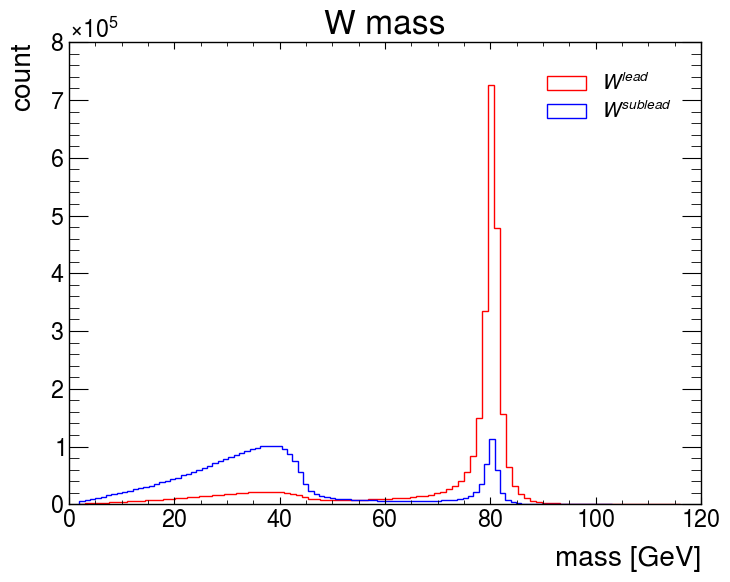

int_kin shape: (1378510,)
<class 'numpy.ndarray'>


In [5]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# sperate onshell and offshell W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
onshell_mask = (w_lead["m"] > w_sublead["m"]).to_numpy()
cut_onshell_mask = (w_lead[PRE_CUT]["m"] > w_sublead[PRE_CUT]["m"]).to_numpy()
base_acc = w_lead[onshell_mask].shape[0] / w_lead.shape[0]
cut_acc  = w_lead[PRE_CUT][cut_onshell_mask].shape[0] / w_lead[PRE_CUT].shape[0]
print(f"Base accuracy: {base_acc:.2f}")
print(f"Cut  accuracy: {cut_acc:.2f}")
print(f"Cuts improve: {100 * (cut_acc - base_acc):.2f}%")

# Check (sub)lead W
plt.hist(w_lead["m"] / GEV, bins=100, color="r", histtype="step", label=r"$W^{lead}$")
plt.hist(
    w_sublead["m"] / GEV, bins=100, color="b", histtype="step", label=r"$W^{sublead}$"
)
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()

# Kinematics of interesting variables (target for training)
int_kin = onshell_mask.astype(int)[PRE_CUT]
print("int_kin shape:", int_kin.shape)
print(type(int_kin))

In [6]:
## Observing variables

met = data.MET[["px", "py", "pt", "phi"]]
lead_lep = data.LeadLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]
sublead_lep = data.SubLep[["px", "py", "pz", "E", "pt", "eta", "phi"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1378510, 18)
<class 'numpy.ndarray'>


In [7]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (551404, 18);
Validing data shape: (413553, 18);
Testing data shape: (413553, 18).
Y (Observed)
Training data shape: (551404,);
Validing data shape: (413553,);
Testing data shape: (413553,).


In [8]:
# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=256, activation="selu")(x)
    x = tf.keras.layers.Dense(units=512, activation="selu")(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=2048, activation="selu")(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    x = tf.keras.layers.Dense(units=2048, activation="selu")(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    x = tf.keras.layers.Dense(units=256, activation="selu")(x)
    x = tf.keras.layers.Dense(units=128, activation="selu")(x)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)
    
    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.losses.binary_crossentropy,
        metrics=["accuracy"],
    )

    return model

In [9]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 flatten (Flatten)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 256)               4864      
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              1050624   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0     

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=32,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 128:
        return lr
    else:
        return lr * tf.math.exp(-0.001)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[stop_early,lr_scheduler],
)

Epoch 1/1024


2024-09-02 09:41:07.770610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-02 09:41:07.780295: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55997a5e4fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-02 09:41:07.780351: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-02 09:41:07.791110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-02 09:41:07.951790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-02 09:41:08.093594: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

68/68 - 5s - loss: 0.4486 - accuracy: 0.8021 - val_loss: 0.3564 - val_accuracy: 0.8422 - lr: 5.0000e-05 - 5s/epoch - 79ms/step
Epoch 2/1024
68/68 - 1s - loss: 0.3564 - accuracy: 0.8419 - val_loss: 0.3267 - val_accuracy: 0.8566 - lr: 5.0000e-05 - 1s/epoch - 17ms/step
Epoch 3/1024
68/68 - 1s - loss: 0.3380 - accuracy: 0.8501 - val_loss: 0.3207 - val_accuracy: 0.8592 - lr: 5.0000e-05 - 1s/epoch - 17ms/step
Epoch 4/1024
68/68 - 1s - loss: 0.3310 - accuracy: 0.8528 - val_loss: 0.3164 - val_accuracy: 0.8608 - lr: 5.0000e-05 - 1s/epoch - 17ms/step
Epoch 5/1024
68/68 - 1s - loss: 0.3268 - accuracy: 0.8548 - val_loss: 0.3141 - val_accuracy: 0.8612 - lr: 5.0000e-05 - 1s/epoch - 17ms/step
Epoch 6/1024
68/68 - 1s - loss: 0.3240 - accuracy: 0.8564 - val_loss: 0.3118 - val_accuracy: 0.8622 - lr: 5.0000e-05 - 1s/epoch - 17ms/step
Epoch 7/1024
68/68 - 1s - loss: 0.3219 - accuracy: 0.8569 - val_loss: 0.3108 - val_accuracy: 0.8628 - lr: 5.0000e-05 - 1s/epoch - 18ms/step
Epoch 8/1024
68/68 - 1s - loss: 0

In [11]:
# Make a directory
dir_name = HOME_PATH + "/5th_trial/classifier/"
name = "shell_classifier"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save model
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"].flatten()
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"].flatten()

Directory /root/work/QE-mls/5th_trial/classifier/ cleaned.
Directory /root/work/QE-mls/5th_trial/classifier/ exists.
12924/12924 [==============================] - 20s 2ms/step


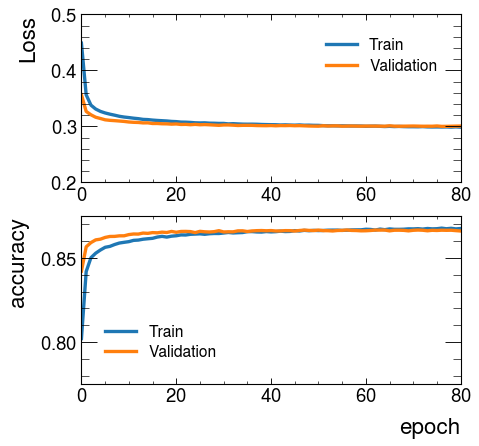

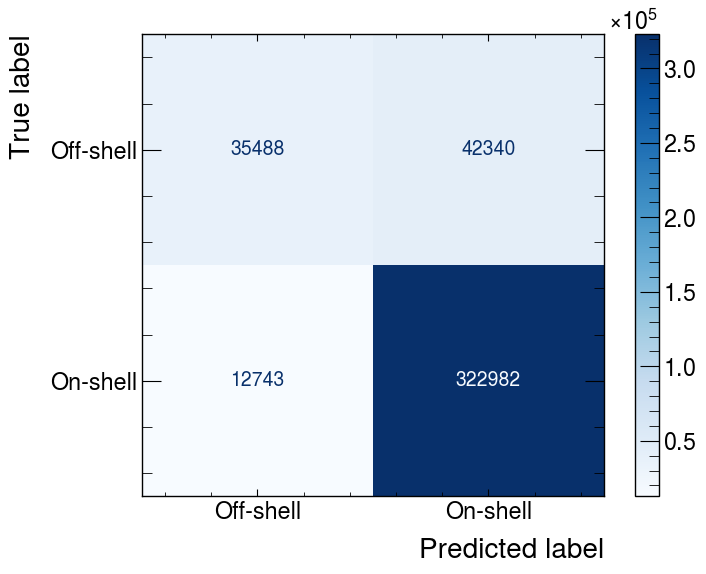

In [12]:
fig = plt.figure(figsize=(6,6), dpi=80)
plt.subplot(2,1,1)
plt.plot(history.history['loss'], lw=3, label='Train')
plt.plot(history.history['val_loss'], lw=3, label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], lw=3, label='Train')
plt.plot(history.history['val_accuracy'], lw=3, label='Validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

predicted = tf.squeeze(sig_pred) # ensure the dimension is correct (dim-1)
predicted = np.where(predicted >= 0.5, 1, 0)
labeled = np.where(sig_truth >= 0.5, 1, 0)
actual = np.array(sig_truth)

conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Off-shell", "On-shell"]) 
displ.plot(cmap='Blues')

ML accuracy: 0.88
ML (base) improve: 5.45%
ML (cuts) improve: 7.21%


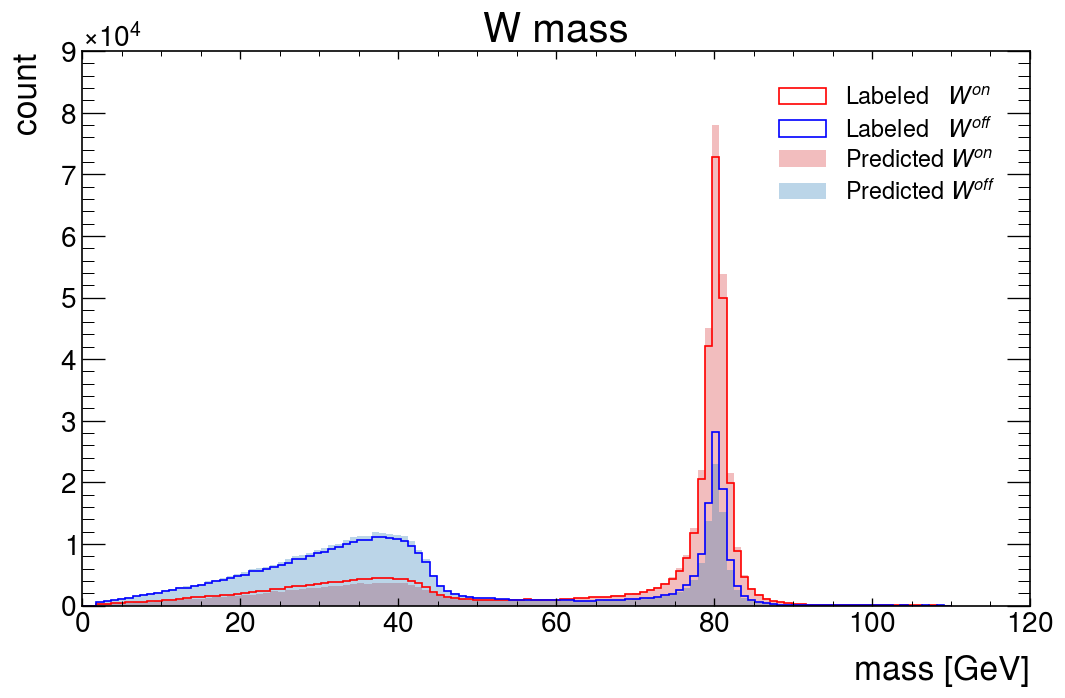

In [13]:
pred_lead_w_m = w_lead["m"][test_indices].reset_index()
pred_sublead_w_m = w_sublead["m"][test_indices].reset_index()
truth_lead_w_m = w_lead["m"][test_indices].reset_index()
truth_sublead_w_m = w_sublead["m"][test_indices].reset_index()
pred_lead_on_mask = predicted.astype(bool)
pred_sublead_on_mask = ~predicted.astype(bool)
label_lead_on_mask = labeled.astype(bool)
label_sublead_on_mask = ~labeled.astype(bool)
pred_w_onshell = pd.concat([pred_lead_w_m[pred_lead_on_mask],pred_sublead_w_m[pred_sublead_on_mask]], axis=0).sort_index()
pred_w_offshell = pd.concat([pred_lead_w_m[pred_sublead_on_mask],pred_sublead_w_m[pred_lead_on_mask]], axis=0).sort_index()
w_onshell = pd.concat([truth_lead_w_m[label_lead_on_mask], truth_sublead_w_m[label_sublead_on_mask]], axis=0).sort_index()
w_offshell = pd.concat([truth_lead_w_m[label_sublead_on_mask], truth_sublead_w_m[label_lead_on_mask]], axis=0).sort_index()

ml_acc = np.sum(predicted*1) / len(predicted)
print(f"ML accuracy: {ml_acc:0.2f}")
print(f"ML (base) improve: {100 * (ml_acc - base_acc):.2f}%")
print(f"ML (cuts) improve: {100 * (ml_acc - cut_acc):.2f}%")


figure = plt.figure(figsize=(10, 6), dpi=120)
bin_edges = np.linspace(0, 110, 121)
plt.hist(w_onshell["m"] / GEV, bins=bin_edges, color="r", histtype="step", label=r"Labeled   $W^{on}$")
plt.hist(w_offshell["m"] / GEV, bins=bin_edges, color="b", histtype="step", label=r"Labeled   $W^{off}$")
plt.hist(pred_w_onshell["m"] / GEV, bins=bin_edges, color="tab:red", histtype="bar", alpha=0.3, label=r"Predicted $W^{on}$")
plt.hist(pred_w_offshell["m"] / GEV, bins=bin_edges, color="tab:blue", histtype="bar", alpha=0.3, label=r"Predicted $W^{off}$")
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()

/root/miniconda3/envs/tf/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


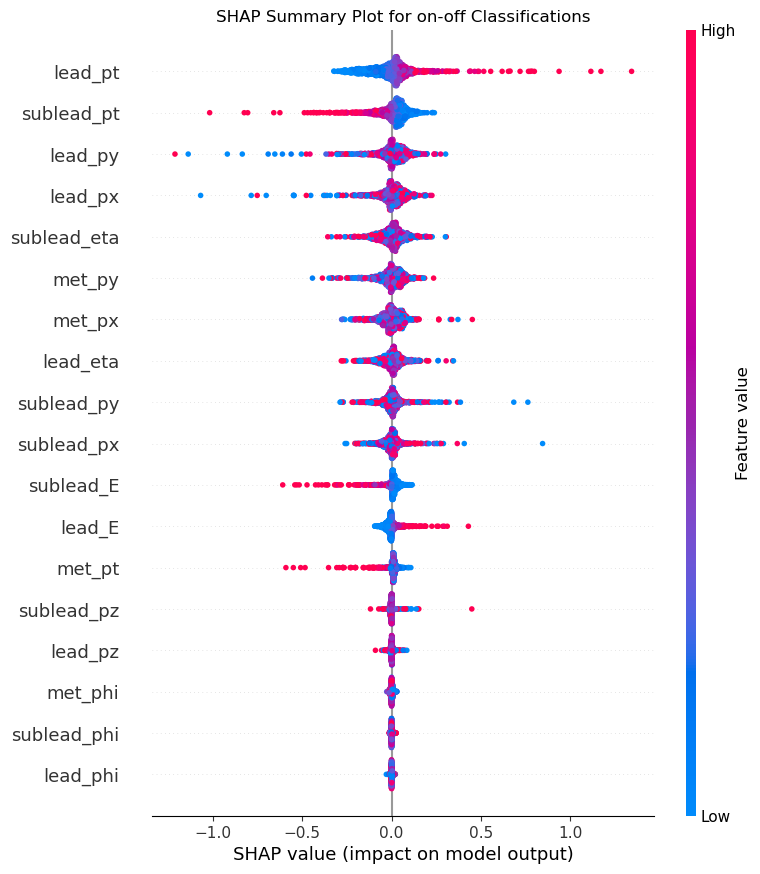

In [14]:
import shap
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

feature_names = [
    "lead_px",
    "lead_py",
    "lead_pz",
    "lead_E",
    "lead_pt",
    "lead_eta",
    "lead_phi",
    "sublead_px",
    "sublead_py",
    "sublead_pz",
    "sublead_E",
    "sublead_pt",
    "sublead_eta",
    "sublead_phi",
    "met_px",
    "met_py",
    "met_pt",
    "met_phi"
]

# Use DeepExplainer for SHAP values
explainer = shap.DeepExplainer(model, obs_kin[:1_024])
shap_values = explainer.shap_values(obs_kin[:1_024])
for i in range(shap_values.shape[-1]):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[:, :, i],
        obs_kin[:1_024],
        feature_names=feature_names,
        plot_type="dot",
        show=False,
    )
    plt.title(f"SHAP Summary Plot for on-off Classifications")
    plt.show()